In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
import os
import h5py
import sparseqr
import LSsurf

plt.rcParams['animation.ffmpeg_path'] = os.path.join(os.environ['CONDA_PREFIX'],'bin','ffmpeg')

# Load Data

In [2]:
datafile = '/home/jovyan/shared-public/off_track/michael/ATL11/n_grn/n_grn_merged_ATL11.h5'
D = pc.data().from_h5(datafile, group='/')
print(D)
print('Lat0: ' + str(D.latitude[0]))
print('Lon0: ' + str(D.longitude[0]))

<class 'pointCollection.data.data'> with shape (149310,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y']
Lat0: 78.15940165098804
Lon0: -70.17445378972863


# Determine spatial and temporal span and center of data

In [3]:
# Compute span and center of x and y coordinates to be used later to determine span and center of reconstructed grid.
x_max = D.x.max()
x_min = D.x.min()
x_cen = (x_min + x_max)/2
x_span = x_max - x_min
y_max = D.y.max()
y_min = D.y.min()
y_cen = (y_min + y_max)/2
y_span = y_max - y_min

print('Span x: ' + str(x_span))
print('Center x: ' + str(x_cen))
print('Span y: ' + str(y_span))
print('Center y: ' + str(y_cen))

# Convert t from seconds since 1 Jan 2018 to decimal years 
D.assign(t = 2018.0 + D.delta_time/(365.25*86400))

# Compute span and center of t
t_min = np.nanmin(D.t)
t_max = np.nanmax(D.t)
t_cen = round(4*(t_min + t_max)/2)/4
t_span = t_max - t_min
print('Span t: ' + str(t_span))
print('Center t: ' + str(t_cen))

# Populate z, sigma fields used by LSurf with corresponding fields in input data.
D.assign(z = np.copy(D.h_corr))
D.assign(sigma = np.copy(D.h_corr_sigma))

Span x: 19994.707636107574
Center x: -543501.7622474495
Span y: 19993.112764325924
Center y: -1174799.8683875024
Span t: 5.063165838877694
Center t: 2021.75


<class 'pointCollection.data.data'> with shape (149310,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y', 't', 'z', 'sigma']

# Plot input measurements

Text(0, 0.5, 'Y (m)')

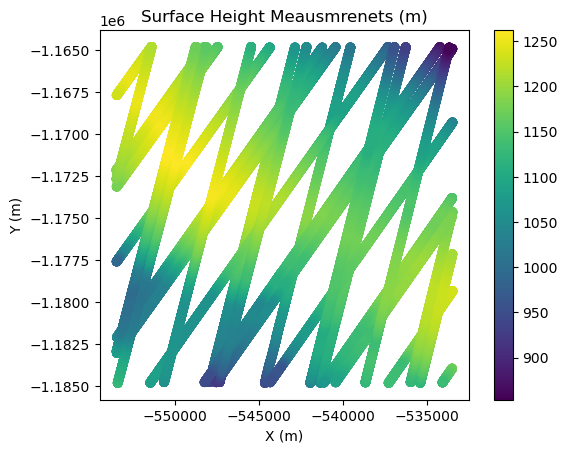

In [5]:
plt.figure()
plt.scatter(D.x, D.y, c=D.z)
plt.gca().set_aspect(1)
plt.colorbar()
plt.title('Surface Height Meausmrenets (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

# Set up LSurf Optimization

In [7]:
from LSsurf.smooth_fit import smooth_fit

E_d3zdx2dt=0.00001 # d/dt of the el diff map curvature. Default = 0.02
E_d2z0dx2=0.06 # 2nd diff of base el map.  Default = 0.00005
E_d2zdt2=5000 # Second time deriv of el diff.  Default = 200000

data=D.copy()
print(data)

ctr={'x':x_cen,'y':y_cen,'t':t_cen} # Data center
print(ctr)
# Width of data in x, y, t
W={'x':2e4,'y':2e4,'t':6} # Numbers should span whats in data. Units don't matter. I use round numbers that are larger than actual spans
print(W)
spacing={'z0':100, 'dz':500, 'dt':0.25} # z0 is elevation spacing, dz is el. diff spacing, dt is temporal spacing between el. diff surfaces.
# Default (ATL14/15).  z0 = 100, dz = 1000.  dt = 0.25.

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}
max_iterations = 5

<class 'pointCollection.data.data'> with shape (149310,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y', 't', 'z', 'sigma']
{'x': -543501.7622474495, 'y': -1174799.8683875024, 't': 2021.75}
{'x': 20000.0, 'y': 20000.0, 't': 6}


In [8]:
# run the fit
S=smooth_fit(data=data, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=max_iterations,
             VERBOSE=True, dzdt_lags=[1])

dz=S['m']['dz']
z0=S['m']['z0']
dz.t=dz.time
dz.cell_area=np.tile(dz.cell_area[:,:,None], [1,1, len(dz.t)])

smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 1e-05, 'd2z_dxdt': 0.025, 'd2z_dt2': 5000}
initial: 94376:
starting qr solve for iteration 0 at Thu Aug 22 20:58:28 2024
found 90672 in TSE, dt=100
	 median(sigma_extra)=0.1044
starting qr solve for iteration 1 at Thu Aug 22 21:00:08 2024
found 89417 in TSE, dt=105
	 median(sigma_extra)=0.0917
starting qr solve for iteration 2 at Thu Aug 22 21:01:53 2024
found 88551 in TSE, dt= 90
	 median(sigma_extra)=0.0864
starting qr solve for iteration 3 at Thu Aug 22 21:03:23 2024
found 87838 in TSE, dt=106
	 median(sigma_extra)=0.0832
starting qr solve for iteration 4 at Thu Aug 22 21:05:09 2024


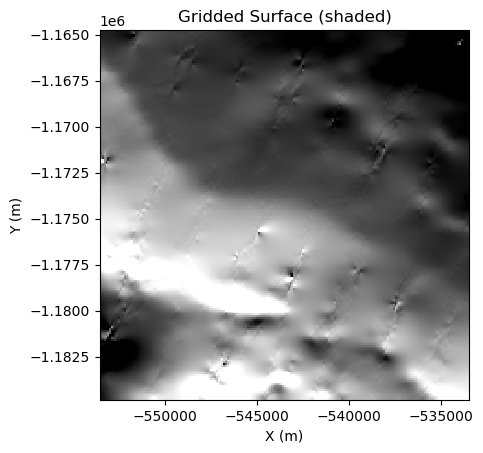

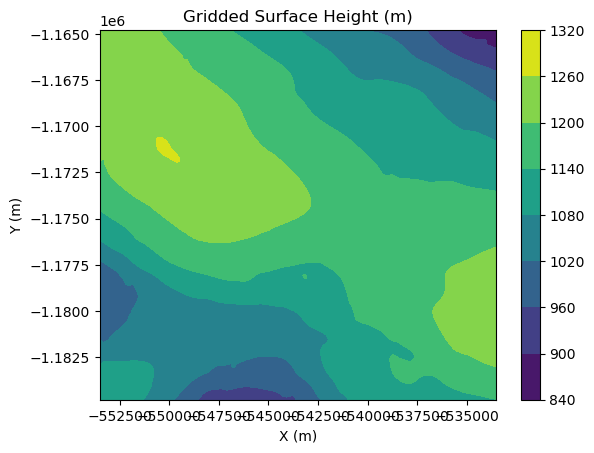

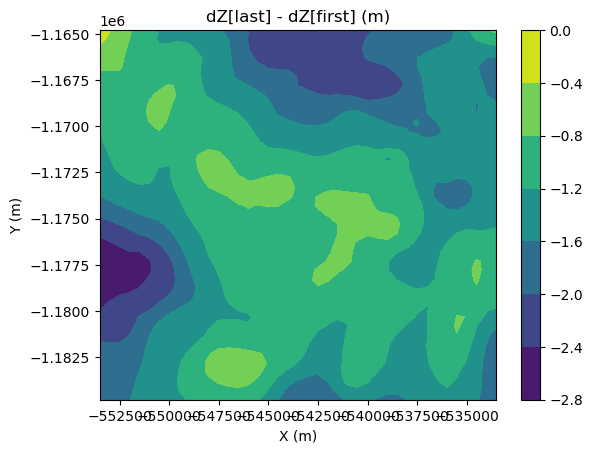

In [65]:
z0.show(gradient=True, field='z0', origin='lower', extent = z0.extent)
plt.title('Gridded Surface (shaded)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

x0, y0 = np.meshgrid(z0.x, z0.y)
plt.contourf(x0, y0, z0.z0[:,:], origin='lower', extent = dz.extent)
plt.colorbar()
plt.title('Gridded Surface Height (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

xd, yd = np.meshgrid(dz.x, dz.y)
plt.contourf(xd, yd, dz.dz[:,:,-1]-dz.dz[:,:,0], origin='lower', extent = dz.extent)
plt.colorbar()
plt.title('dZ[last] - dZ[first] (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()
plt.show()

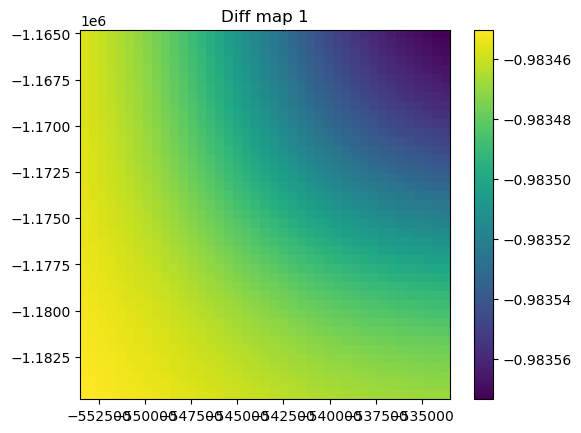

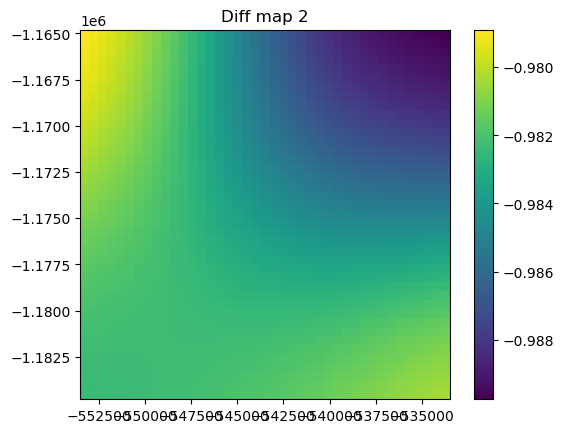

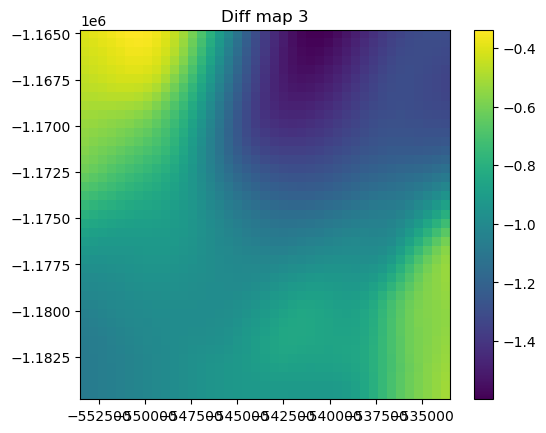

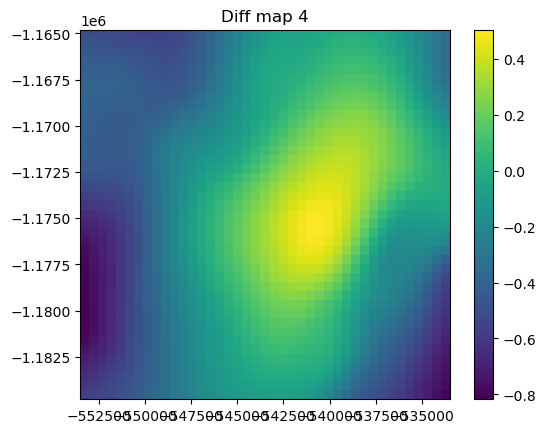

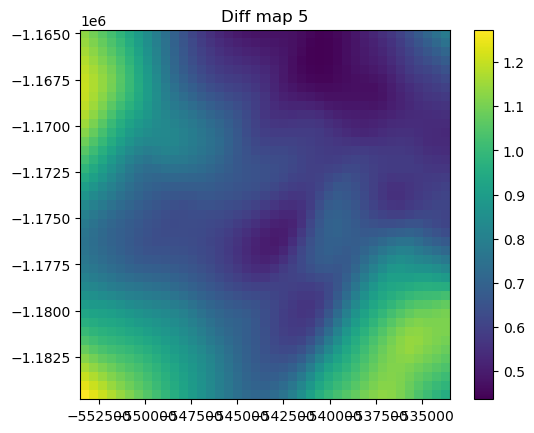

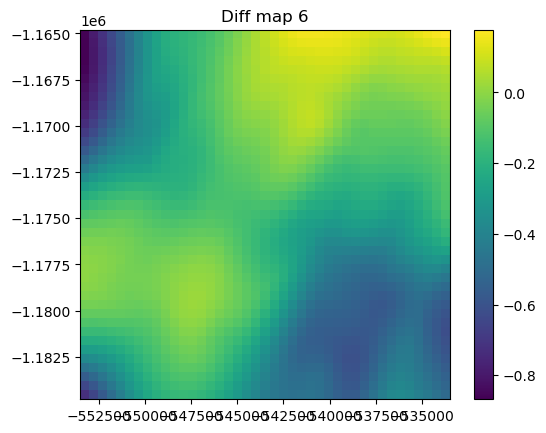

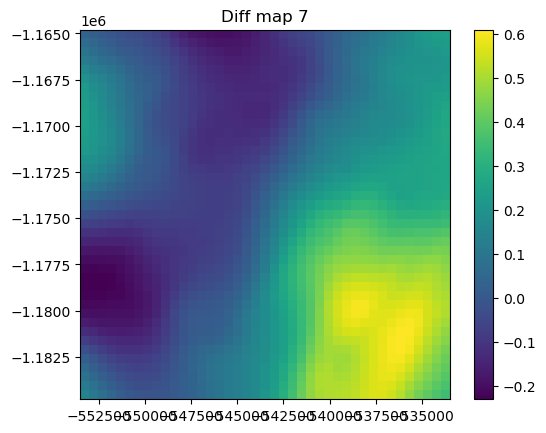

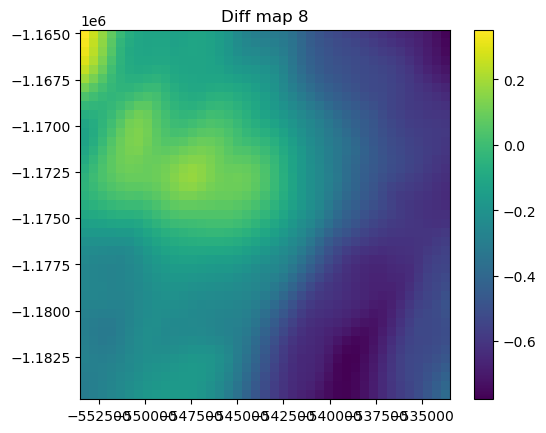

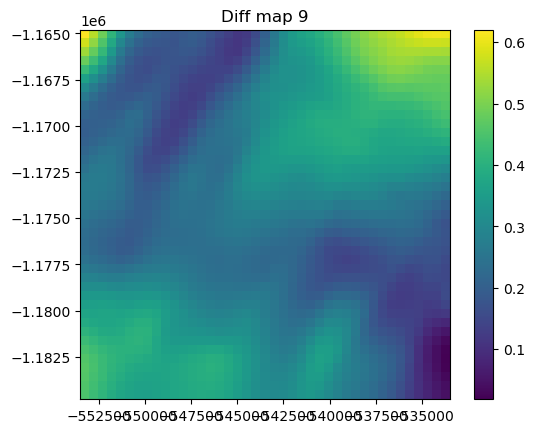

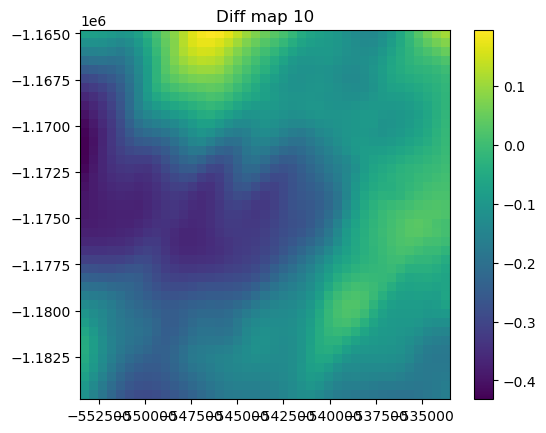

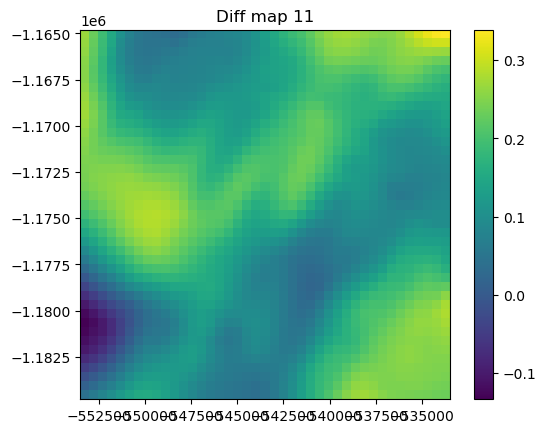

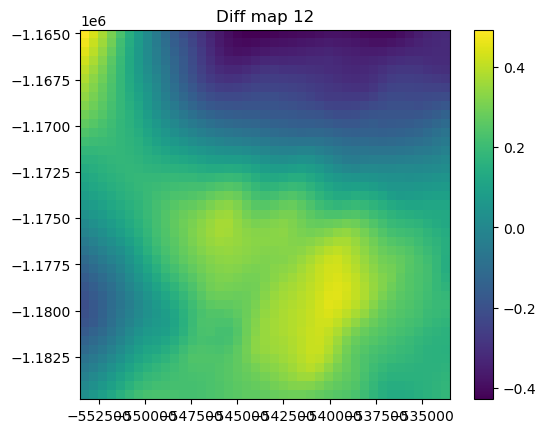

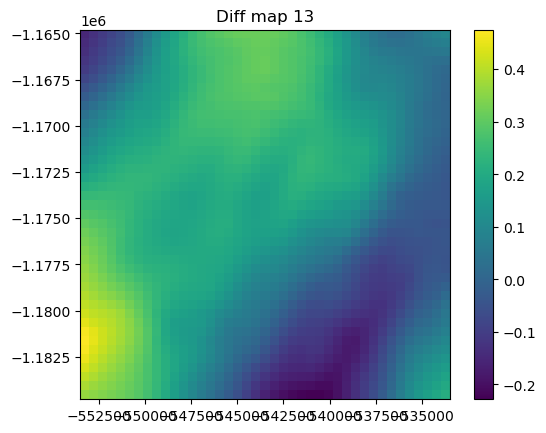

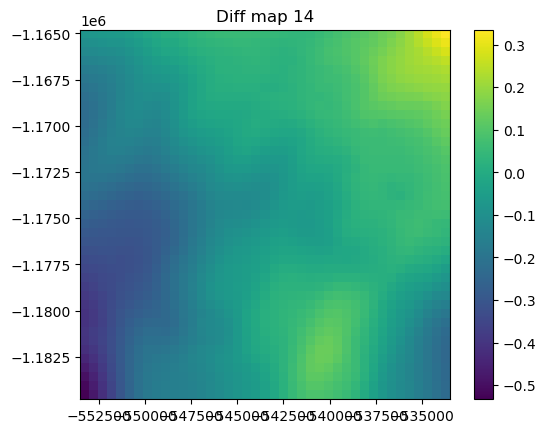

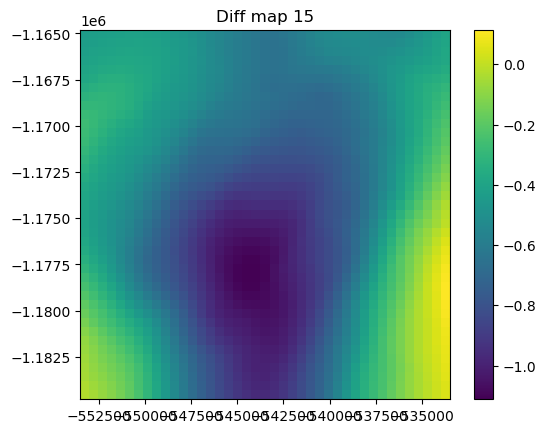

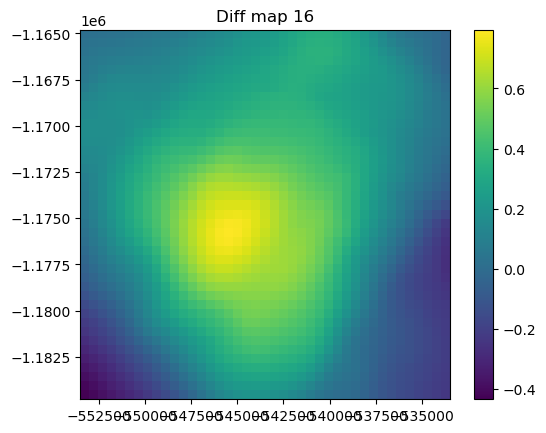

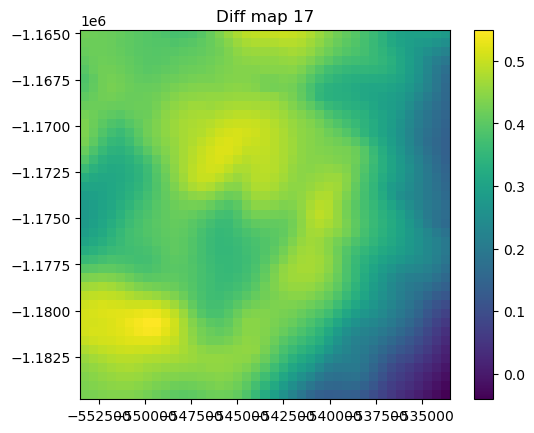

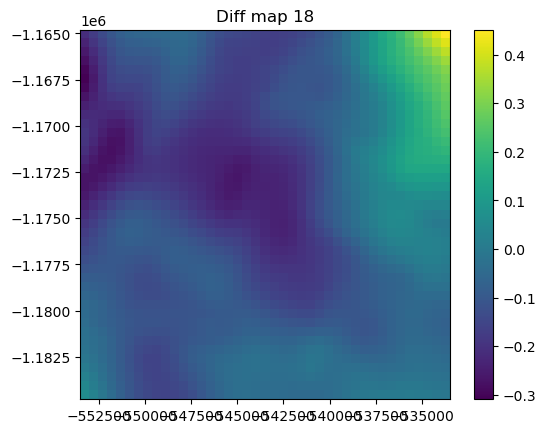

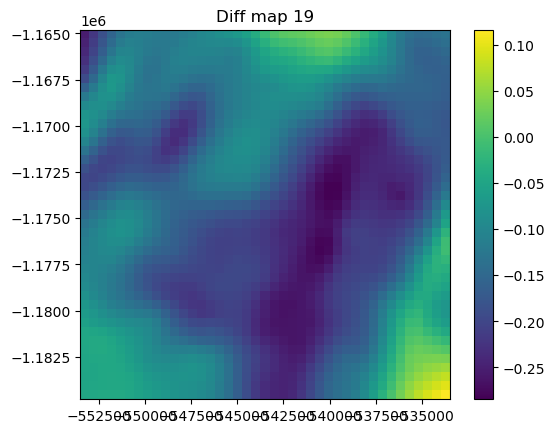

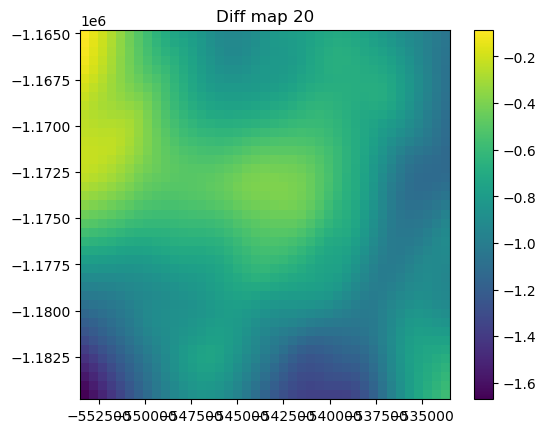

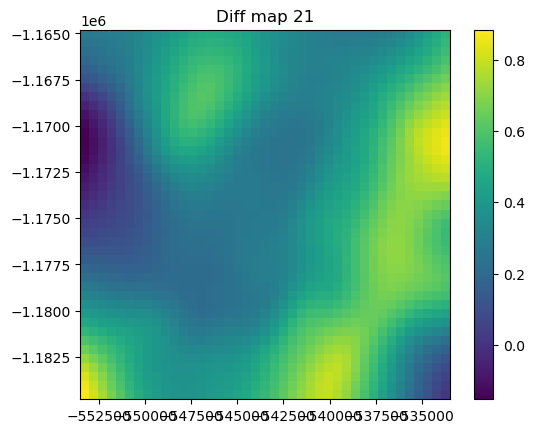

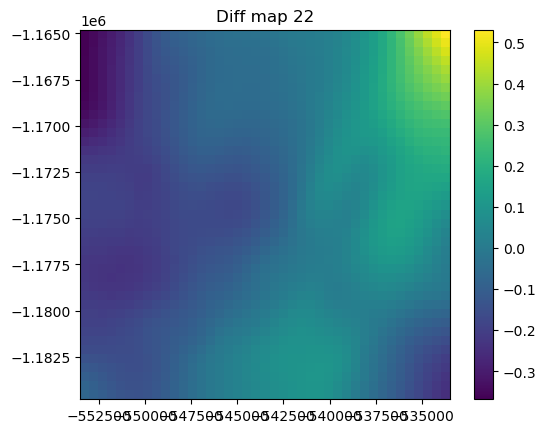

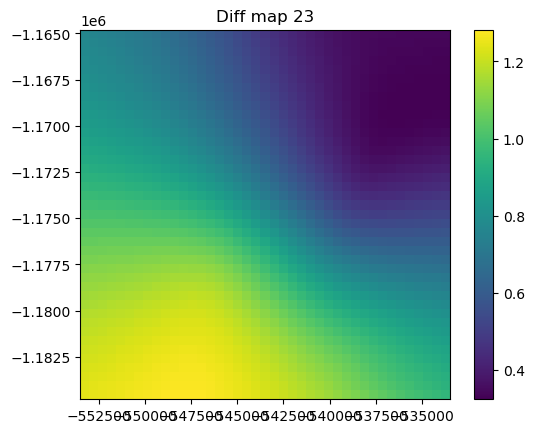

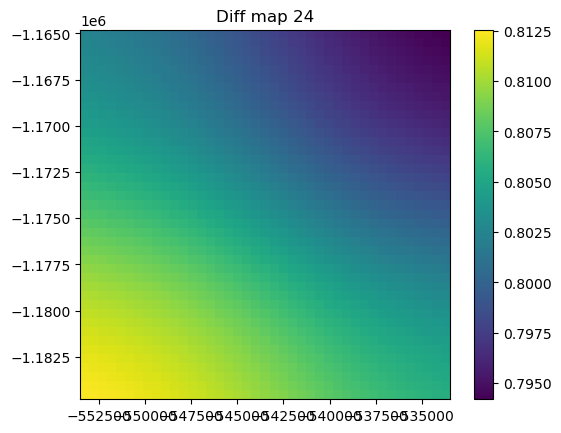

In [21]:
for i in range(1, dz.shape[2]):
    plt.imshow(dz.dz[:,:,i]-dz.dz[:,:,i-1], origin='lower', extent = dz.extent)
    plt.colorbar()
    plt.title('Diff map {}'.format(i))
    plt.show()


In [10]:
#import geopandas as gpd
#df=gpd.read_file('/home/jovyan/shared-public/off_track/michael/BASINS/Mouginot/Mouginot_GRN_basins_v142.gpkg').to_crs(3413)
#xy=np.array(df.geometry[0].exterior.coords)
#D.crop([[np.min(xy[:,0]), np.max(xy[:,0])], [np.min(xy[:,1]), np.max(xy[:,1])]])

In [52]:
z0.shape

(201, 201)

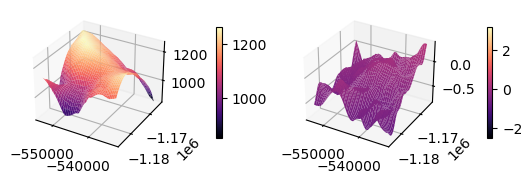

In [35]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
xg0, yg0=np.meshgrid(z0.x, z0.y)
zmin = np.nanmin(z0.z0)
zmax = np.nanmax(z0.z0)
hs=ax[0].plot_surface(xg0, yg0, z0.z0, vmin=zmin, vmax=zmax, cmap='magma')
plt.colorbar(hs, location='right', pad=0.2, shrink=0.3)

xgd, ygd=np.meshgrid(dz.x, dz.y)
dzmin = np.nanmin(dz.dz)
dzmax = np.nanmax(dz.dz)
hs1=ax[1].plot_surface(xgd, ygd, dz.dz[:,:,10], vmin=dzmin, vmax=dzmax, cmap='magma')
plt.colorbar(hs1, location='right', pad=0.2, shrink=0.3)

NameError: name 'times' is not defined

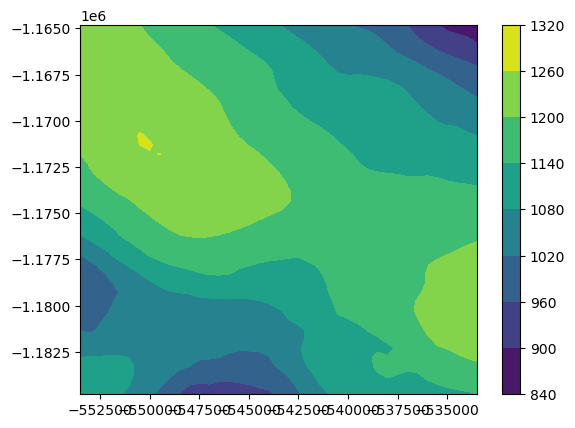

In [67]:
xg, yg=np.meshgrid(dz.x, dz.y)
zg0 = z0.interp(xg, yg, field='z0')
plt.contourf(xg, yg, zg0)
plt.colorbar()

i0 = 5
ii = D.t<=times[i0]
print(ii.shape)

dzi=dz.interp(xg, yg, np.zeros_like(zg0)+times[i0], field='dz')
shape(dzi)

-553501.7622474495

In [68]:
from matplotlib import animation

def make_frame(i0, times, D, z0, dz, hax, zlim, dzlim):
    """The animation function to call for each animation frame."""
    for ax in hax:
        ax.clear()

    ii = D.t<=times[i0]
    ax=hax[0]
    hs=ax.scatter(D.x[ii][::5], D.y[ii][::5], D.z[ii][::5], c=D.z[ii][::5], vmin=zlim[0], vmax=zlim[1], cmap='magma')
    hs.set_facecolors(hs.get_facecolors()*np.array([0.25, 0.25, 0.25, 1]))
    hs.set_sizes([1])

    ii=(D.t>=times[i0]) & (D.t <= times[i0+1]) 
    hs1=ax.scatter(D.x[ii], D.y[ii], D.z[ii], c=D.z[ii],  vmin=zlim[0], vmax=zlim[1], cmap='magma')
    hs1.set_sizes([2])

    xg, yg=np.meshgrid(dz.x, dz.y)
    zg0 = z0.interp(xg, yg, field='z0')
    dzi=dz.interp(xg, yg, np.zeros_like(zg0)+times[i0], field='dz')
    surf0 = hax[1].plot_surface(*np.meshgrid(z0.x, z0.y), z0.z0, vmin=zlim[0], vmax=zlim[1], cmap='magma')
    surf1 = hax[2].plot_surface(xg, yg, dzi, vmin=dzlim[0], vmax=dzlim[1], cmap='viridis')
    surf2=hax[3].plot_surface(xg, yg, zg0 + dzi, vmin=zlim[0], vmax=zlim[1], cmap='magma')
    ht=[hax[0].set_title('Data', color='white'),
        hax[1].set_title('reference DEM', color='white'),
        hax[2].set_title('elevation change', color='white'),
        hax[3].set_title('Total elevation', color='white')]

    for ix, ax in enumerate(hax):
        if ix == 2:
            ax.set_zlim(dzlim)
        else:
            ax.set_zlim(zlim)
    return hax[0], hax[1], hs, hs1, surf0, surf1, surf2, *ht


def make_animation(D, dz, z0, t_steps, zlim, dzlim):

    # 3D surface plot, black backgrounds, no padding around the Axes.
    fig, hax = plt.subplots(2,2, figsize=[8, 8], 
                            subplot_kw=dict(projection='3d', facecolor='k'),
                           facecolor='k', gridspec_kw={'left':0,'right':1, 'bottom':0.0,'top':0.9})
    hax=hax.ravel()
    # Initialize the plot.
    _ = make_frame(0, t_steps, D, z0, dz, hax, zlim, dzlim)
    #for ax in hax:
    #    ax.axis('off')

    # The animation itself; no point in blitting: almost everything will change
    # in each animation frame.
    ani = animation.FuncAnimation(fig, make_frame, fargs=(t_steps, D, z0, dz, hax, zlim,dzlim),
                                  interval=100, blit=False, frames=len(t_steps)-1)
    
    
    return ani

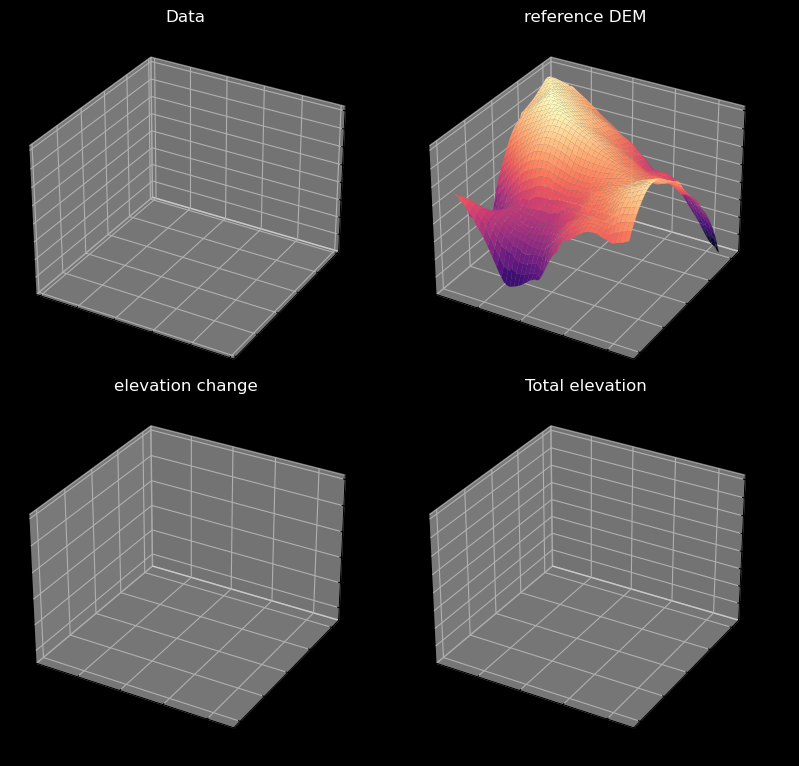

In [71]:
t_steps=np.arange(3*91, 18*91, 10)/365.25
fig, hax = plt.subplots(2,2, figsize=[8, 8], 
                        subplot_kw=dict(projection='3d', facecolor='k'),
                       facecolor='k', gridspec_kw={'left':0,'right':1, 'bottom':0.0,'top':0.9,
                                                  'hspace':0.05,'wspace':0})
hax=hax.ravel()

zlim=[zmin, zmax]
dzlim=[dzmin, dzmax]

_ = make_frame(20, t_steps, data, z0, dz, hax.ravel(), zlim, dzlim)